<div style="font-size: 32px; color: gray; font-weight: bold; text-align: center;">Stock Analysis</div>

---

In [1]:
# Libraries
# import yfinance as yf
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns; sns.set_theme(color_codes=True)
import pandas as pd
import numpy as np
import boto3
from io import StringIO
from sagemaker import get_execution_role
import warnings
warnings.filterwarnings("ignore")
import pickle
from scipy import stats
plt.style.use('seaborn-white')
import numpy as np

In [2]:
# print(plt.style.available)

## Get data

### Retrieve ticker info data from s3

In [3]:
# Read ticker_info from s3

s3 = boto3.client("s3")

#Read the object stored in key 'myList001'
object = s3.get_object(Bucket="euronext-stocks", Key="ticker_info")
# object = s3.get_object(Bucket="euronext-stocks", Key="ticker_info_test")
serializedObject = object['Body'].read()
ticker_info = pickle.loads(serializedObject) # Deserialize the retrieved object

### Retrieve price data from s3

In [4]:
# Read data from s3
role = get_execution_role()
bucket="euronext-stocks"
data_key = "df_prices.csv"
data_location = 's3://{}/{}'.format(bucket, data_key)
df_prices = pd.read_csv(data_location,)
df_prices.set_index(df_prices["Date"], drop=True, inplace=True)
df_prices.drop("Date", axis=1, inplace=True)
df_prices.index = pd.to_datetime(df_prices.index)
df_prices.interpolate(method='linear', inplace=True) # use linear interpolation for missing values

In [5]:
df_prices.shape

(513, 706)

## Create data frame of raw prices

In [6]:
df_raw_prices = df_prices.copy()

### Create dataframe of % daily returns

In [7]:
df_daily_returns = df_prices.pct_change()

In [8]:
df_daily_returns.shape

(513, 706)

### Create dataframe of returns from period 0 with sector and industry headings

In [9]:
# Use ticker metadata in column headings of df_prices dataframe
col_tuples = [(ticker_info[ticker][1], ticker_info[ticker][2], ticker) for ticker in ticker_info] # sector and industry
df_prices.columns = col_tuples
df_prices.columns = pd.MultiIndex.from_tuples(df_prices.columns,)

# Tidy up ordering and grouping on column headers
new_columns = df_prices.columns.sort_values(ascending=[True, True, True])
df_prices = df_prices[new_columns]

In [10]:
df_prices.shape

(513, 706)

In [11]:
# df_prices.head()

## Slicing

In [12]:
# Filter by date
# df_prices.loc['2021-01-01':'2021-01-31']

In [13]:
# Get sectors
df_prices.columns.get_level_values(0).unique()[2:].to_list() # full dataset
# df_prices.columns.get_level_values(0).unique().to_list() # test dataset

['Communication Services',
 'Consumer Cyclical',
 'Consumer Defensive',
 'Energy',
 'Financial',
 'Financial Services',
 'Healthcare',
 'Industrial Goods',
 'Industrials',
 'Missing',
 'Real Estate',
 'Services',
 'Technology',
 'Utilities']

In [14]:
# Get industries
df_prices.columns.get_level_values(1).unique()[2:].to_list() # full dataset
# df_prices.columns.get_level_values(1).unique().to_list() # test data

['Aluminum',
 'Building Materials',
 'Chemicals',
 'Gold',
 'Lumber & Wood Production',
 'Other Industrial Metals & Mining',
 'Paper & Paper Products',
 'Specialty Chemicals',
 'Steel',
 'Advertising Agencies',
 'Broadcasting',
 'Electronic Gaming & Multimedia',
 'Entertainment',
 'Internet Content & Information',
 'Publishing',
 'Telecom Services',
 'Apparel Manufacturing',
 'Apparel Retail',
 'Auto & Truck Dealerships',
 'Auto Manufacturers',
 'Auto Parts',
 'Footwear & Accessories',
 'Furnishings, Fixtures & Appliances',
 'Gambling',
 'Home Improvement Retail',
 'Internet Retail',
 'Leisure',
 'Lodging',
 'Luxury Goods',
 'Packaging & Containers',
 'Recreational Vehicles',
 'Residential Construction',
 'Resorts & Casinos',
 'Restaurants',
 'Specialty Retail',
 'Textile Manufacturing',
 'Travel Services',
 'Beverages—Brewers',
 'Beverages—Non-Alcoholic',
 'Beverages—Wineries & Distilleries',
 'Confectioners',
 'Farm Products',
 'Food Distribution',
 'Grocery Stores',
 'Household & Pe

In [15]:
# Get latest values for all stocks in a particular sector/industry combination
sector = "Utilities"
industry = "Utilities—Renewable"
# df_prices[sector][industry].iloc[107].sort_values(ascending=False)

In [16]:
# Get data for all stocks in a particular sector
# df_prices.xs("Energy", axis=1, level=0, drop_level=False)

In [17]:
# Get data for all stocks in a particular industry
# df_prices.xs("Utilities—Renewable", axis=1, level=1, drop_level=False)
# df_prices.xs("Utilities—Diversified", axis=1, level=1, drop_level=False)

In [18]:
# Get stock tickers in a particular sector
print([item[2] for item in df_prices.xs("Energy", axis=1, level=0, drop_level=False).columns.to_list()])

['EC.PA', 'LFDE.PA', 'MAU.PA', 'CGG.PA', 'CLB.AS', 'FTI.PA', 'FUR.AS', 'GTT.PA', 'SBMO.AS', 'SLB.PA', 'TE.PA', 'VPK.AS', 'RDSA.AS', 'RDSB.AS', 'EURN.BR', 'EXM.BR', 'FLUX.BR', 'DPAM.PA', 'ES.PA']


In [19]:
# Get stock tickers in a particular industry
[item[2] for item in df_prices.xs("Internet Retail", axis=1, level=1, drop_level=False).columns.to_list()]

['ALX.AS', 'CNV.PA', 'SRP.PA', 'TKWY.AS']

In [20]:
# Get list of dicts of ticker and ticker names for a sector. Can use this to generate tickers_to_plot below
sector = "Energy"
[{ticker:ticker_info[ticker][0]} for ticker in [item[2] for item in df_prices.xs(sector, axis=1, level=0, drop_level=False).columns.to_list()]]

[{'EC.PA': 'Total Gabon'},
 {'LFDE.PA': "La Française de l'Energie S.A."},
 {'MAU.PA': 'Etablissements Maurel & Prom S.A.'},
 {'CGG.PA': 'CGG'},
 {'CLB.AS': 'Core Laboratories N.V.'},
 {'FTI.PA': 'TechnipFMC plc'},
 {'FUR.AS': 'Fugro N.V.'},
 {'GTT.PA': 'Gaztransport & Technigaz SA'},
 {'SBMO.AS': 'SBM Offshore N.V.'},
 {'SLB.PA': 'Schlumberger Limited'},
 {'TE.PA': 'Technip Energies N.V.'},
 {'VPK.AS': 'Royal Vopak N.V.'},
 {'RDSA.AS': 'Royal Dutch Shell plc'},
 {'RDSB.AS': 'Royal Dutch Shell plc'},
 {'EURN.BR': 'Euronav NV'},
 {'EXM.BR': 'Exmar NV'},
 {'FLUX.BR': 'Fluxys Belgium SA'},
 {'DPAM.PA': "Les Docks des Pétroles d'Ambès -SA"},
 {'ES.PA': 'Esso S.A.F.'}]

In [21]:
# Get list of dicts of ticker and ticker names for an industry. Can use this to generate tickers_to_plot below
industry = "Internet Retail"
[{ticker:ticker_info[ticker][0]} for ticker in [item[2] for item in df_prices.xs(industry, axis=1, level=1, drop_level=False).columns.to_list()]]

[{'ALX.AS': 'Alumexx N.V.'},
 {'CNV.PA': 'Cnova N.V.'},
 {'SRP.PA': 'SRP Groupe S.A.'},
 {'TKWY.AS': 'Just Eat Takeaway.com N.V.'}]

## Plotting

### Plot functions

In [22]:
# Plot a single stock Close price and several moving averages
def plot_single_ticker(ticker, start_date, end_date):
    
    
    base = df_raw_prices.loc[start_date:end_date][ticker]
    rolling_20 = np.round(base.rolling(window=20, center=False).mean(), 2)
    rolling_50 = np.round(base.rolling(window=50, center=False).mean(), 2)
    rolling_200 = np.round(base.rolling(window=200, center=False).mean(), 2)

    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(base, label="Close", linewidth=4, alpha=.2)
    ax.plot(rolling_20, label="20d M.A.", linestyle="dashed", linewidth=2)
    ax.plot(rolling_50, label="50d M.A.", linestyle="dashed", linewidth=2)
    ax.plot(rolling_200, label="200d M.A.", linestyle="dashed", linewidth=2)
    ax.set_ylabel("Close Price")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.set_title(f"{ticker}\n{start_date} to {end_date}")
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()

In [23]:
# Plot multiple stocks or indices against each other and customize the legend labels

# *** NEED TO IMPLEMENT ***
# - volumes?

def plot_tickers(tickers_to_plot, start_date, end_date):
    """
    Function to plot a stock against an index (or other stock) and customize the legend labels.
    Input is a list of key:pairs (python dicts) in the form ticker:ticker description
    """
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)
    
    # Baseline the data at start date and convert to percentages
    df_plot = df_prices.loc[start_date:end_date]
    df_plot = (df_plot/df_plot.iloc[0] - 1) * 100
    
    for ticker in tickers_to_plot:
        df_plot.xs(list(ticker.keys())[0], axis=1, level=2, drop_level=False).plot(ax=ax)
        
    lines, labels = ax.get_legend_handles_labels()
    
    mylabels = [list(ticker.values())[0] for ticker in tickers_to_plot]
    
    ax.legend(lines, mylabels, loc='best')  # legend for first two lines only
    ax.set_xlabel(""); ax.set_ylabel("Return %")
    ax.set_title(f"% Returns\n{start_date} & {end_date}")
    plt.grid()

In [24]:
# Regression plot
def regression_plot(ticker1, ticker2, start_date, end_date):
    
    # Transform data for alpha, beta and plotting
    data = pd.DataFrame(
        {
            ticker1:[item[0] for item in df_prices.loc[start_date:end_date].xs(ticker1, axis=1, level=2, drop_level=False).values.tolist()],
            ticker2:[item[0] for item in df_prices.loc[start_date:end_date].xs(ticker2, axis=1, level=2, drop_level=False).values.tolist()]
        }
    )

    data_returns = (data/data.iloc[0] - 1) * 100
    
    (beta, alpha) = stats.linregress(data_returns[ticker2],
                    data_returns[ticker1])[0:2]

#     fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(12,8))
    ax = sns.regplot(x=ticker2, y=ticker1, data=data_returns)
    ax.set_title(f"Regression plot for\n{ticker2} vs {ticker1}\nbetween {start_date} & {end_date}\nBeta={round(beta, 4)}\nAlpha={round(alpha,5)}")
    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_major_locator(MultipleLocator(10))
    plt.gca().set_aspect("equal")
    plt.grid()
    plt.show()

In [25]:
# Compare volatility of 2 tickers
def plot_vol_comparison(ticker1, ticker2):
    """
    1. 2-year vol comparison. (*** Could update to have dynamic date ranges ***)
    2. Uses standard deviation for vol calculation.
    """
    tickers = [ticker1, ticker2]
    fig, ax = plt.subplots(figsize=(10,6))
    for ticker in tickers:
        vol = np.std(df_daily_returns[ticker])
        df_daily_returns[ticker].hist(bins=50, ax=ax, label=f"{ticker} = {vol:.3f}", alpha=.5)
    plt.legend()
    plt.title("Volatility Comparison")
    plt.tight_layout()

In [26]:
# Heatmap displaying correlation of daily returns for a group of tickers
def plot_corr_daily_returns(tickers):
    
    corr = df_daily_returns[tickers].corr()
    # corr.style.background_gradient(cmap='Blues', axis=None) # display dataframe zith pandas in-built styling

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(corr, cmap="rocket_r", ax=ax, square=True, annot=True, fmt=".1g", annot_kws={"size":8}, mask=mask) # plot heatmap with seaborn
    # icefire
    
    plt.title("Correlation of daily returns")
    plt.tight_layout()

### Single stock

In [27]:
ticker = "VLTSA.PA"
start_date = '2020-04-25'
end_date = '2021-04-25'

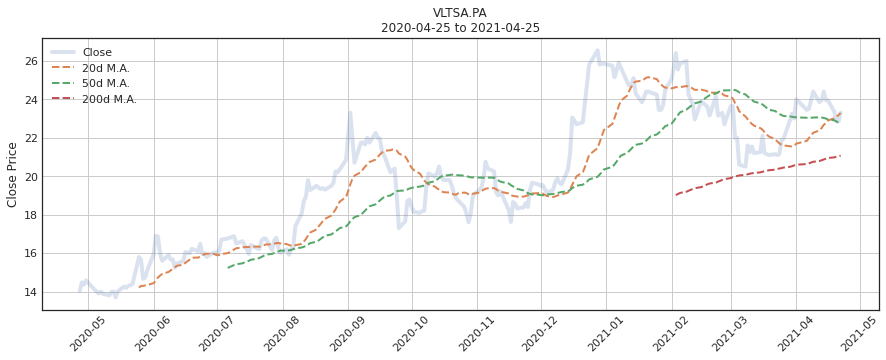

In [28]:
# Single stock close price with moving averages
plot_single_ticker(ticker, start_date, end_date)

### Return comparisons

In [29]:
start_date = '2019-04-23'
end_date = '2021-04-30'

In [30]:
# Specify tickers to plot individually:
tickers_to_plot = [
    {"VLTSA.PA":"Voltalia"},
    {"ES.PA":"Esso"},
    {"RDSA.AS":"Royal Dutch Shell plc"},
    {"RDSB.AS":"Royal Dutch Shell plc"},
#     {"^FCHI":"CAC40 Index"},
#     {"^N100":"Euronext Index"},
]

# Plot all tickers in a sector:
# sector = "Energy"
# tickers_to_plot =  [{ticker:ticker_info[ticker][0]} for ticker in [item[2] for item in df_prices.xs(sector, axis=1, level=0, drop_level=False).columns.to_list()]]

# Plot all tickers in an industry:
# industry = "Internet Retail"
# tickers_to_plot =  [{ticker:ticker_info[ticker][0]} for ticker in [item[2] for item in df_prices.xs(industry, axis=1, level=1, drop_level=False).columns.to_list()]]

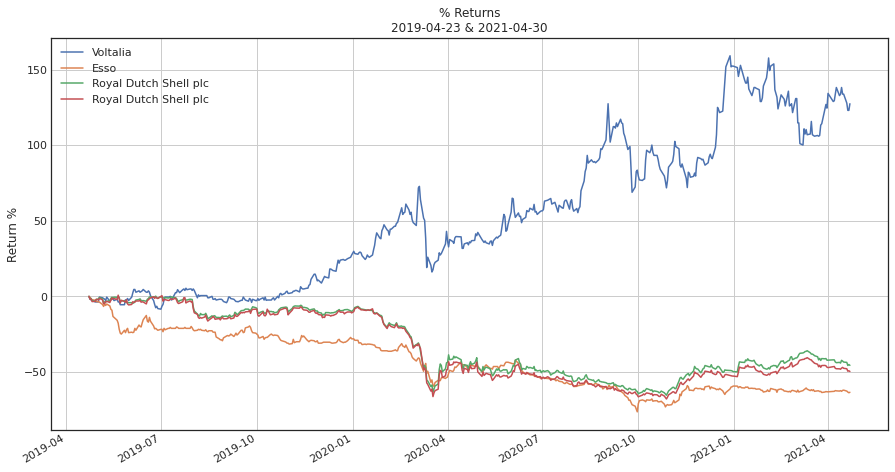

In [31]:
# Compare returns of multiple stocks / indices
plot_tickers(tickers_to_plot, start_date, end_date)

### Alpha & Beta

In [32]:
ticker1 = "VLTSA.PA"
# ticker1 = "TKWY.AS"
# ticker1 = "^N100" # Euronext index
# ticker2 = "^FCHI" # CAC40 index
ticker2 = "SU.PA" # CAC40 index

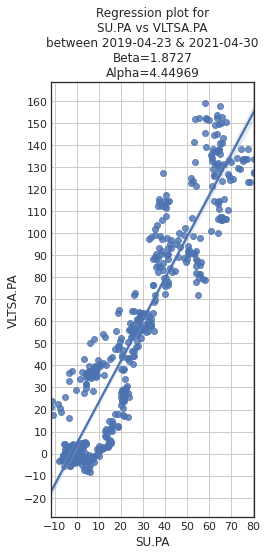

In [33]:
# Plot regression, alpha and beta comparing 2 tickers
regression_plot(ticker1, ticker2, start_date, end_date)

### Volatility

In [34]:
ticker1 = "VLTSA.PA"
ticker2 = "SU.PA"
# ticker1 = "^N100" # Euronext index
# ticker2 = "^FCHI" # CAC40 index

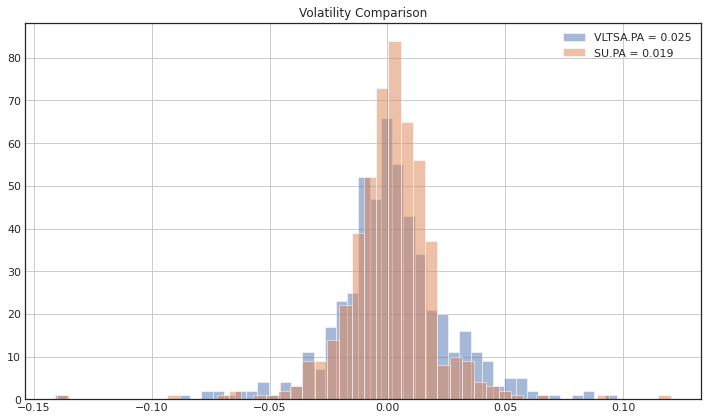

In [35]:
# Plot comparison of volatility of daily returns between 2 tickers
plot_vol_comparison(ticker1, ticker2)

### Correlation matrix

In [36]:
tickers = ['EC.PA', 'LFDE.PA', 'MAU.PA', 'CGG.PA', 'CLB.AS', 'FTI.PA', 'FUR.AS', 'GTT.PA', 'SBMO.AS', 'SLB.PA', 'TE.PA', 'VPK.AS', 'RDSA.AS', 'RDSB.AS', 'EURN.BR', 'EXM.BR', 'FLUX.BR', 'DPAM.PA', 'ES.PA']
# tickers = ["VLTSA.PA", "ES.PA"]

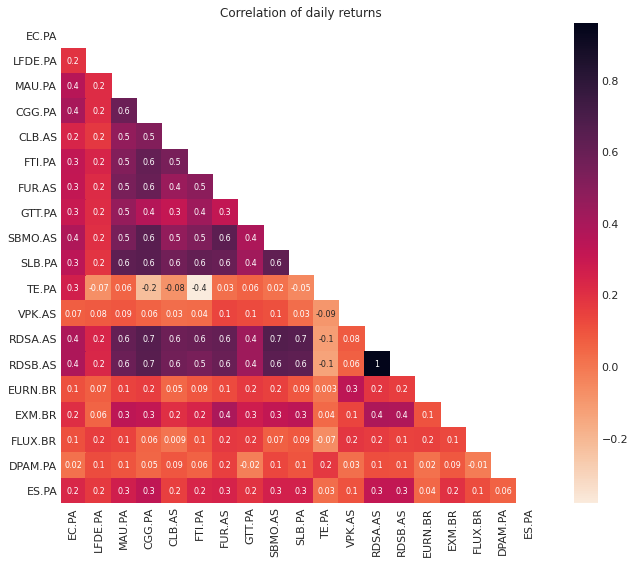

In [37]:
# Plot correlation of returns between group of tickers
plot_corr_daily_returns(tickers)

### Test widgets

In [38]:
import ipywidgets as widgets

In [39]:
widgets.Dropdown(
    options=['1', '2', '3'],
    value='2',
    description='Number:',
    disabled=False,
)

Dropdown(description='Number:', index=1, options=('1', '2', '3'), value='2')

Dropdown(description='Ticker:', options=('VLTSA.PA', 'ES.PA'), value='VLTSA.PA')

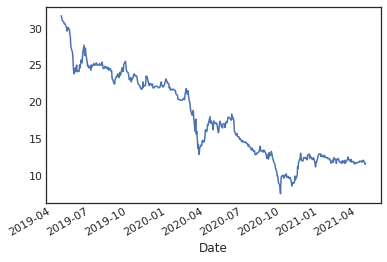

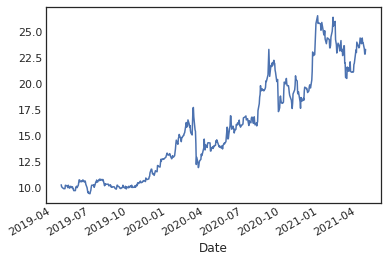

In [42]:
def test_plot(ticker):
    df_raw_prices[ticker].plot()

w = widgets.Dropdown(
    options=["VLTSA.PA", "ES.PA"],
    description='Ticker:',
    disabled=False
)

w.observe(
    lambda c: test_plot(c['new']) if (c['type'] == 'change' and c['name'] == 'value') else None
)

display(w)